In [1]:
import warnings
import umap
import torch

import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn import decomposition, preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from collections import Counter
from scipy import stats
from scipy.spatial import distance

from IPython.display import display, Markdown

from torch.nn import functional as F

from news_vec.encoder import read_preds

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [4]:
df, embeds = read_preds('../data/fox/')

100%|██████████| 58/58 [00:01<00:00, 33.44it/s]


In [5]:
df.label.unique()

array(['foxnews.com.0', 'foxnews.com.1'], dtype=object)

In [6]:
embeds.shape

(58000, 512)

In [14]:
dr = decomposition.TruncatedSVD(10)
embedding = dr.fit_transform(embeds[df.index])

In [15]:
dr.explained_variance_ratio_

array([0.62051326, 0.25654197, 0.03697393, 0.0099748 , 0.00655938,
       0.00599896, 0.00496279, 0.00346708, 0.00301064, 0.00242639],
      dtype=float32)

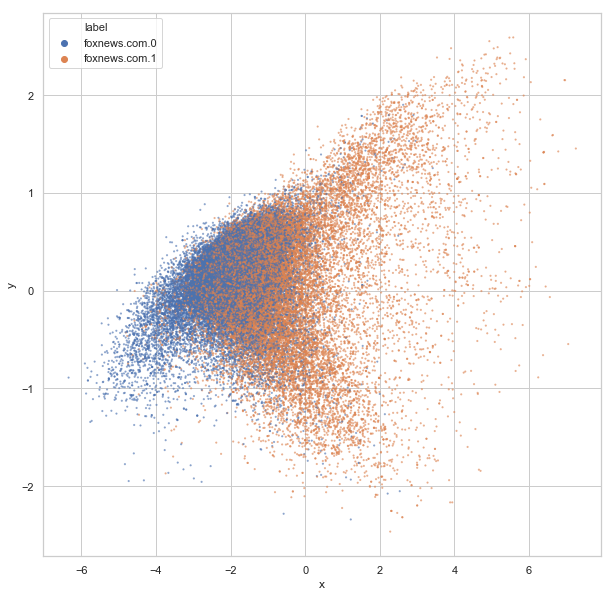

In [18]:
points = df.copy()
points['x'] = embedding[:,1]
points['y'] = embedding[:,2]

plt.figure(figsize=(10,10))

sns.scatterplot(
    x='x',
    y='y',
    data=points,
    s=2,
    edgecolor=None,
    alpha=0.5,
    hue='label',
)

In [20]:
pdf = df.copy()
pdf['tokens_key'] = pdf.clf_tokens.apply(lambda ts: tuple(ts))
pdf = pdf.drop_duplicates('tokens_key')

dr = umap.UMAP(metric='euclidean', verbose=True)
UMAP_EMBEDDING = dr.fit_transform(embeds[pdf.index])

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


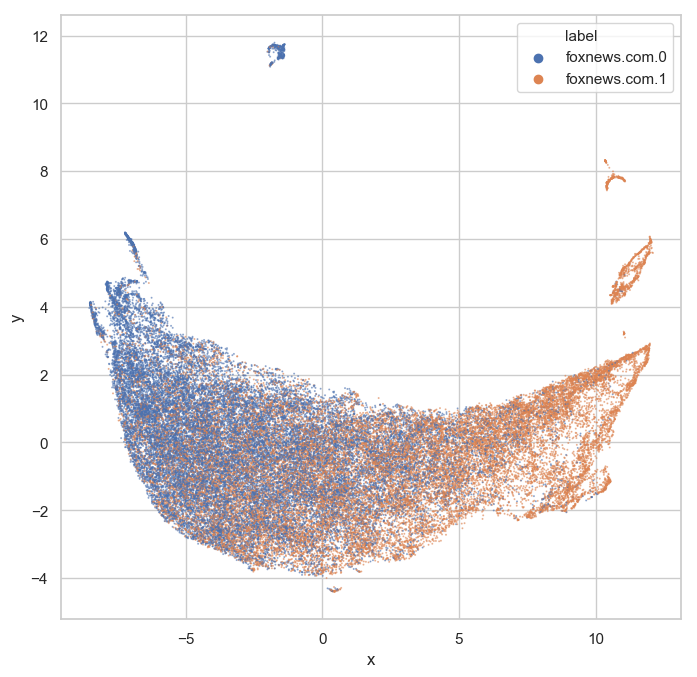

In [24]:
UMAP_POINTS = pdf.copy()
UMAP_POINTS['x'] = UMAP_EMBEDDING[:,0]
UMAP_POINTS['y'] = UMAP_EMBEDDING[:,1]

plt.figure(figsize=(8,8), dpi=100)

sns.scatterplot(
    x='x',
    y='y',
    data=UMAP_POINTS,
    s=0.5,
    edgecolor=None,
    alpha=0.5,
    hue='label',
)

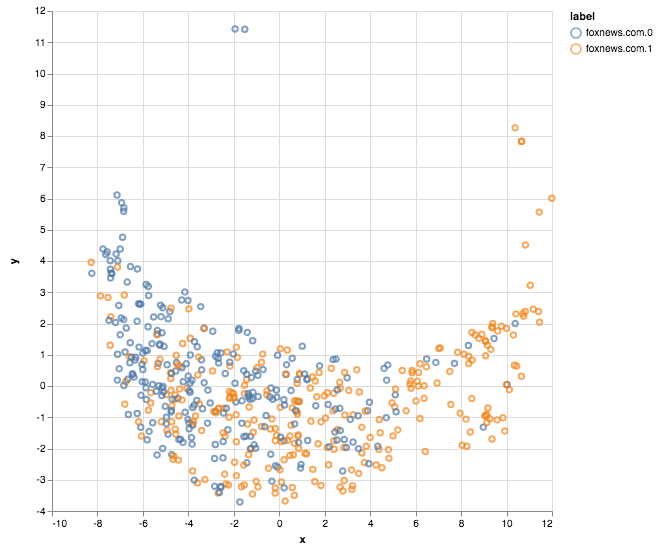

In [25]:
(alt
    .Chart(UMAP_POINTS.sample(frac=0.01), width=500, height=500)
    .mark_point()
    .encode(x='x', y='y', tooltip='title', color='label'))